# <font color=#025dfa> Derin Öğrenme Classificion ile Tweet Duygu Analizi - Twitter Sentiment Analysis with Deep Learning Classification

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, XXXIV SEMAC kapsamında düzenlenen hackathon için tweet verilerini kullanarak yapay zeka, derin öğrenme ile duygu analizi yapmayı amaçlamaktadır. 

EN = This project aims to perform sentiment analysis with artificial intelligence and deep learning using tweet data for the hackathon organized within the scope of XXXIV SEMAC.

Kaynak/Source = https://www.kaggle.com/competitions/hackathon-semac-xxxiv

In [7]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install googletrans==4.0.0-rc1

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import time
import math
import warnings
warnings.filterwarnings('ignore') 
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from autocorrect import spell
from textblob import TextBlob
from langdetect import detect
from googletrans import Translator
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
pd.set_option("display.max_columns",None) 
# TR = En fazla kaç sütun olduğunu gösteriyor. 
# EN = It shows the maximum number of columns.

In [12]:
df=pd.read_csv('/kaggle/input/hackathon-semac-xxxiv/train.csv')

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis

In [13]:
df.head()

,ID,text,feeling
0,1.0,J@lisastarlyRnEI haven't heard anytVing. I'll ...,0.0
1,2.0,Just grabbed some bagelLt from Pdnera for ever...,0.0
2,3.0,@poepjaqndzegiant oopY just saw you said hello...,1.0
3,4.0,@kirsty_gilfo yuj! That's the one MmL....yuom...,1.0
4,5.0,pMum's off to bed... NipUtuck time noow,1.0


In [14]:
df.sample(5)

,ID,text,feeling
3779,3780.0,finally going tF bUed..i donit think I would e...,1.0
18957,19884.0,MY COMhUTER WOFRKS!!..but all of my files and ...,0.0
1138,1139.0,"feelzlike i'm on a boat, jWuFst ignore me havi...",1.0
8883,8884.0,"@MicRelleDK Oh, I seRe...E have you watchfd Le...",1.0
1231,1232.0,"@NKOTB I mean rowI11. Phoenix showl, sectiTn 1...",1.0


In [15]:
df.tail()

,ID,text,feeling
19069,19996.0,@BrennaCeDrUia That sucks. I'm Uso sorry Qto h...,0.0
19070,19997.0,dNeed to shll it for financial reasons bux it'...,0.0
19071,19998.0,p@curtsmith LLok chilly - I Ithink I woupld st...,1.0
19072,19999.0,I'm grarduating today!L Four yearsSsweet too ...,1.0
19073,20000.0,@mickeymab Gmine's inpmy prPofile - 'e77cb550 ...,1.0


In [16]:
df.shape

(19074, 3)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19074 entries, 0 to 19073
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       18429 non-null  float64
 1   text     18429 non-null  object 
 2   feeling  18429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 447.2+ KB


In [18]:
df.isnull().sum().sort_values(ascending=False)

ID         645
text       645
feeling    645
dtype: int64

## <font color=#C0C0C0> Gereksiz Verileri Silme İşlemi Yapıyoruz - We Delete Unnecessary Data

In [19]:
df=df.drop('ID',axis=1)
df.head(1)

,text,feeling
0,J@lisastarlyRnEI haven't heard anytVing. I'll ...,0.0


## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [20]:
for column in df.columns:
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
        unique = sorted(unique)
        
    nunique = len(unique)  # Benzersiz değerlerin sayısını hesapla
    # TR = Benzersiz değerlerin sayısını hesaplar  
    # EN = Calculates the number of unique values

    print(f"Nunique Değerler: {nunique}")  
    # TR = Benzersiz değerlerin sayısını ekrana yazdırır  
    # EN = Prints the number of unique values

    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values


Sütun: text
Nunique Değerler: 18429
Unique Değerler: ["J@lisastarlyRnEI haven't heard anytVing. I'll tweet you as aoon as I hear. I'mvQreallyxworrxied actually"
 "Just grabbed some bagelLt from Pdnera for everyone at wk. It's Brittany's last day"
 '@poepjaqndzegiant oopY just saw you said helloM! Hi there' ...
 'p@curtsmith LLok chilly - I Ithink I woupld stay in and read a book'
 "I'm grarduating today!L  Four yearsSsweet too fast."
 "@mickeymab Gmine's inpmy prPofile - 'e77cb550 and hectoH's is a 'J2 bmw q75/5 there's Fmore photWos oh Kmy fb. checck out alabama roadtrip!"]

Sütun: feeling
Nunique Değerler: 2
Unique Değerler: [0.0, 1.0]


In [21]:
df=df.dropna()

In [22]:
df['text'][0]

"J@lisastarlyRnEI haven't heard anytVing. I'll tweet you as aoon as I hear. I'mvQreallyxworrxied actually"

In [23]:
def algo_text(df):

  for col in df.columns:
    if df[col].dtype=='object':
      df[col] = df[col].str.lower()
      df[col] = df[col].str.replace('[^\w\s]', '', regex=True)
      df[col] = df[col].str.replace('\n', '')
      df[col] = df[col].str.replace('\d', '')
      df[col] = df[col].str.replace('\r', '')
      df[col] = df[col].str.replace('.', '')
      df[col] = df[col].str.replace(',', '')
    return df
    # TR = Bu kod data type object olan verilerin buluyor ve onlarda istenmeyen işartetleri kaldırıyor.
    # EN = This code finds the data with data type object and removes the unwanted marks from them.

df=algo_text(df)

In [24]:
df.head()

,text,feeling
0,jlisastarlyrnei havent heard anytving ill twee...,0.0
1,just grabbed some bagellt from pdnera for ever...,0.0
2,poepjaqndzegiant oopy just saw you said hellom...,1.0
3,kirsty_gilfo yuj thats the one mmlyuom cha uh...,1.0
4,pmums off to bed niputuck time noow,1.0


In [25]:
df['text'][0]

'jlisastarlyrnei havent heard anytving ill tweet you as aoon as i hear imvqreallyxworrxied actually'

In [26]:
def detect_veri(reviewText):
    try:
        return detect(reviewText)
    except:
        return 'unknown'
    # TR = Text sütunundaki verilerin hangi dillerde yazıldığını tespit etme.
    # EN = Detecting in which languages ​​the data in the text column is written.

start_time = time.time()
# TR = start_time adında bir değişken tanımla, time.time() kodu ile şimdiki zamanı al.
# EN = Define a variable called start_time and get the current time with the time.time() code.

df['language']=df['text'].apply(detect_veri)
# TR = language diye yeni bir sütün oluşturma. Oluşan yeni sütunu text bulunduğu sütunun .apply(detect_veri) kodu ile hangi dilde yazıldığını bul.
# EN = Creating a new column called language. Find the language in which the new column contains text, using the .apply(detect_veri) code.

end_time = time.time()
# TR = end_time adında bir değişken tanımla, time.time() kodu ile şimdiki zamanı al.
# EN = Define a variable called end_time and get the current time with the time.time() code.


elapsed_time = end_time - start_time
# TR = Dil tespitin ne kadar sürdüğünü bulmak için end_time'dan start_time'mı çıkar.
# EN = Subtract start_time from end_time to find how long language detection took.
print({elapsed_time}, "saniye")

{278.7263345718384} saniye


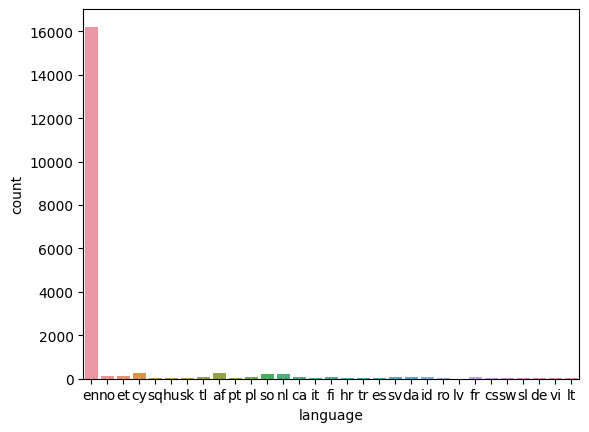

In [27]:
sns.countplot(x=df['language']);

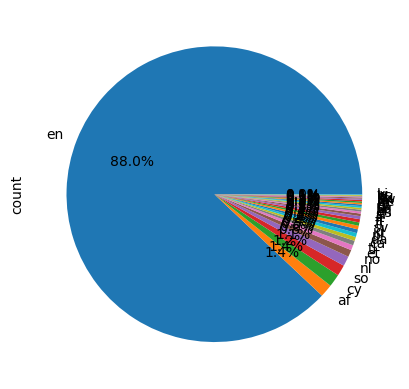

In [28]:
df['language'].value_counts().plot.pie(autopct='%1.1f%%');

In [29]:
df = df[df['language'] == 'en']
# TR = language sütunundaki verilerin 'en' kelimesine eşit olduğu satırları seçer.
# EN = Selects rows where the values in the 'language' column are equal to 'en'.

df.drop(index=df[df['language'] != 'en'].index, inplace=True)
# TR = language sütunundaki 'en' kelimesine eşit olmayan satırları siler.
# EN = Deletes rows in the 'language' column that are not equal to 'en'.


## <font color='#0ceb31'>Duygu Analizi - Sentiment Analysis

### <font color=#06c750>Yorumların Olumlumu ya da Olumsuzmu Olduğunu Tespit Etme - Determining Whether Comments Have Death or Immortality

In [30]:
df['sentiment']=df['feeling']
df['sentiment']=df['sentiment'].replace([1],'olumlu')
df['sentiment']=df['sentiment'].replace([0],'olumsuz')
# TR = sentiment diye yeni bir sütun oluşturup () sütünundaki verilere eşitledik. [1],'olumlu', [0],'olumsuz'
# EN = We created a new column called sentiment and set it equal to the data in the () column. [1],'positive', [0],'negative'

In [31]:
#df=df[['a','b','sentiment']]# a yerine puan ya da yıldız gibi değerini belirten sayı, b yerine yazımızın bulunduğu sütün adı

df=df[['feeling','text','sentiment']]

In [32]:
df=df[(df['sentiment']=='olumlu')|(df['sentiment']=='olumsuz')]
# TR = sentimentimizi olumlu ya da olumsuzolacak şekilde tanımladık.
# EN = We defined our sentiment as positive, negative

In [33]:
df.reset_index(drop=True,inplace=True)
# TR = Yukarıda yaptığımız işlem neticesinde olumlu,notr,olumsuz kelimeler kendi içlerinde üst üste oldular. Bu yüzden indexlerini sıfırlayıp tekrar verdik.
# EN = As a result of the process we did above, positive, neutral and negative words were placed on top of each other. That's why we reset their indexes and gave them again.

In [34]:
x=df['text']
y=df['sentiment']

In [35]:
yelpbw = df[(df.feeling == 0) | (df.feeling == 1)]

In [36]:
yelpbw.reset_index(drop=True,inplace=True)

In [37]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2))

In [38]:
x=yelpbw["text"]
y=yelpbw["feeling"]

In [39]:
vect=CountVectorizer()
x=vect.fit_transform(x)

In [40]:
def lemmafn(Review):
    words=TextBlob.words
    return [pr.stem(word) for word in words]

## <font color=#10e6e6> En çok Sayıdaki Kelimeleri Kap İçine Alma - Containing the Most Numbered Words 

In [41]:
#wc=wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    # TR = Kabımızın boyutunu belirttik.
    # EN = We specified the size of our container.
    
    mask=np.array(Image.open('cloud.png'))
    # TR = Image.open ile resmimizi açtık. np.array resmi diziye çevirdik ve mask değişkenine atadık.
    # EN = We opened our image with Image.open. We converted the np.array image to an array and assigned it to the mask variable.
    
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask)
    # TR = Bir WordCloud tanımladık. Arka plan rengini bgcolor eşitledik. stopwords=STOPWORDS ile gereksiz kelimeleri atıp anahtar kelimeleri sakladık.
    # EN = We defined a WordCloud. We set the background color equal to bgcolor. We removed unnecessary words and kept keywords with stopwords=STOPWORDS

    # TR = mask=mask yukarıda tanımladığımız mask değişkenini kullan.
    # EN = mask=mask use the mask variable we defined above.
    wc.generate(''.join(data))
    # TR = .join(data) ile bütün sütündaki text alıp birleştirecek. 
    # EN = With .join(data) it will take the text in all columns and combine them.

    # TR = İçinde geçen tüm kelimeleri sayacak ve hafızada tutup generate ile tanımladığımız WordCloud oluşturduk ona eşitleyecek. 
    # EN = It will count all the words in it, keep it in memory and synchronize it with the WordCloud we created with generate.
    
    plt.imshow(wc)
    plt.axis('off')
    # TR = Bunla kod ile x ve y gözükmüyor.
    # EN = With this code, x and y do not appear.
    

In [42]:
olumlu=df[df['feeling']==1]['text']
olumsuz=df[df['feeling']==0]['text']

In [43]:
wc(olumlu,'white')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/cloud.png'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
wc(olumsuz,'white')

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling

In [44]:
x=yelpbw["text"]
y=yelpbw["feeling"]

In [45]:
vectorizer = TfidfVectorizer(max_features=5000)
x = vectorizer.fit_transform(x).toarray()

In [46]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [47]:
model=Sequential()
model.add(Dense(1024,activation='relu',input_dim=x_train.shape[1]))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 256 nöron var.
# Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.
# EN = This layer connects all input neurons and learns the weights of each neuron. There are 256 neurons.
# Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(BatchNormalization())
# TR = Bu katman, modelin eğitim sürecini daha stabil hale getirmek için kullanılır.
# EN = This layer is used to make the training process of the model more stable.

model.add(Dropout(0.3))
# TR = Derin öğrenme modelinde aşırı uyumu (overfitting) azaltmak için kullanılır. Genelde 0.2 ile 0.5 arasında olur.
# EN = It is used to reduce overfitting in the deep learning model. It is generally between 0.2 and 0.5.

model.add(Dense(128,activation='relu',input_dim=x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu',input_dim=x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
# TR = Sigmoid fonksiyonu, çıktı değerini 0 ile 1 arasında sınırlayarak iki sınıflı (binary) sınıflandırma problemleri için kullanılır.
# EN = The sigmoid function is used for binary classification problems, limiting the output value between 0 and 1.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 5 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 5 epochs, it stops training and restores the best weights.

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# TR = İkili sınıflandırma (çıktı katmanı sigmoid aktivasyon kullanır).
# TR = Tahmin edilen olasılık ile gerçek ikili etiketler arasındaki farkı ölçer.
# TR = optimizer='adam': Adam (Adaptive Moment Estimation) optimizasyon algoritması, modelin ağırlıklarını güncellerken kullanılan bir yöntemdir.
# TR = metrics=['accuracy']: Modelin performansını değerlendirmek için kullanılan bir ölçümdür. Doğru sınıflandırılan örneklerin toplam örneklere oranını hesaplar.

# EN = Binary classification (output layer uses a sigmoid activation).
# EN = Measures the difference between the predicted probability and the actual binary labels.
# EN = optimizer='adam': Adam (Adaptive Moment Estimation) optimization algorithm is a method used when updating the weights of the model.
# EN = metrics=['accuracy']: A metric used to evaluate the performance of the model. It calculates the ratio of correctly classified examples to total examples.

history=model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5199 - loss: 0.8470 - val_accuracy: 0.5617 - val_loss: 0.6887
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5942 - loss: 0.6734 - val_accuracy: 0.5752 - val_loss: 0.6711
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7212 - loss: 0.5600 - val_accuracy: 0.6253 - val_loss: 0.6386
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7996 - loss: 0.4498 - val_accuracy: 0.6303 - val_loss: 0.6825
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8565 - loss: 0.3423 - val_accuracy: 0.6307 - val_loss: 0.8185
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9075 - loss: 0.2494 - val_accuracy: 0.6222 - val_loss: 0.9635
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9245 - loss: 0.2066 - val_accuracy: 0.6264 - val_loss: 1.0769
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9334 - loss: 0.1767 

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     5,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,799,429 (60.27 MB)

 Trainable params: 5,265,633 (20.09 MB)

 Non-trainable params: 2,528 (9.88 KB)

 Optimizer params: 10,531,268 (40.17 MB)

In [49]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6373 - loss: 0.6298
Test doğruluğu: 0.6377


In [50]:
pred=(model.predict(x_test) > 0.5).astype(int)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik. 
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [51]:
accuracy_score(y_test, pred)
# TR = accuracy_score fonksiyonu ile y_test, pred kullanarak sonucumuzu bulduk.
# EN = We found our result using the accuracy_score function and y_test, pred.

0.6376811594202898

In [52]:
confusion_matrix(y_test, pred)
# TR = confusion_matrix fonksiyonu ile y_test, pred kullanarak ne kadarını yanlış tahmin ettiğimizi buluyoruz
# EN = Using the confusion_matrix function and y_test, pred, we find out how much we guessed wrong.

# TR = 4 sayı değeri veriyor bize. Sol üst ve sağ alt doğru tahmin, sağ üst ve sol alt yanlış tahmin. 
# EN = It gives us 4 number values. Upper left and lower right are correct guesses, upper right and lower left are incorrect guesses.

array([[ 723,  919],
       [ 256, 1345]])

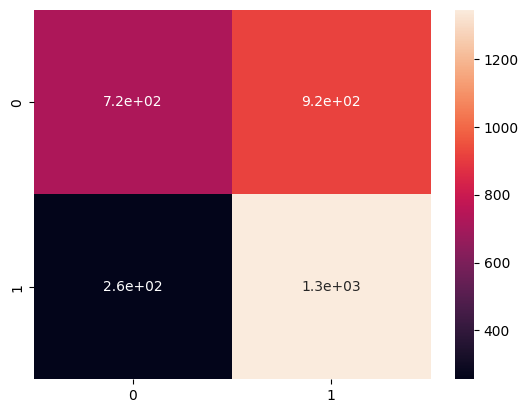

In [53]:
sns.heatmap(confusion_matrix(y_test, pred),annot=True);
# TR = Yukarıdakinin görsel versiyonu.
# EN = Visual version of the above.

In [54]:
print(classification_report(y_test, pred))
# TR = print içinde yazdık yoksa sayıların sıralanması bozuluyor.
# EN = We wrote it in print, otherwise the order of the numbers will be disrupted.

# TR = classification_report ile y_test, pred kullanarak precision, recall, f1-score ve support ulaştık.
# EN = We achieved precision, recall, f1-score and support using classification_report and y_test, pred.

# TR = Precision (Kesinlik): Doğru olarak pozitif tahmin edilen örneklerin, toplam pozitif tahmin edilen örnekler içindeki oranını gösterir. Yani, modelin pozitif sınıfı ne kadar doğru tahmin ettiğini ölçer.
# EN = Precision (Precision): It shows the ratio of correctly predicted positive samples among the total positive predicted samples. That is, it measures how accurately the model predicts the positive class.

# TR = Recall (Duyarlılık): Gerçek pozitif örneklerin, toplam pozitif örnekler içindeki oranını gösterir. Modelin pozitif sınıfı ne kadar iyi bulduğunu ölçer.
# EN = Recall (Sensitivity): Shows the ratio of true positive samples in total positive samples. It measures how well the model finds the positive class.

# TR = F1-score: Precision ve recall'un harmonik ortalamasıdır. Hem precision hem de recall'u dikkate alarak modelin genel performansını özetler.
# EN = F1-score: It is the harmonic mean of precision and recall. It summarizes the overall performance of the model, taking into account both precision and recall.

# TR = Support: Her sınıftan kaç örneğin bulunduğunu gösterir. Yani, gerçek etiketlerde her bir sınıfa ait kaç örnek olduğunu ifade eder.
# EN = Support: Shows how many examples of each class are available. That is, it expresses how many examples of each class there are in the real labels.

              precision    recall  f1-score   support

         0.0       0.74      0.44      0.55      1642
         1.0       0.59      0.84      0.70      1601

    accuracy                           0.64      3243
   macro avg       0.67      0.64      0.62      3243
weighted avg       0.67      0.64      0.62      3243



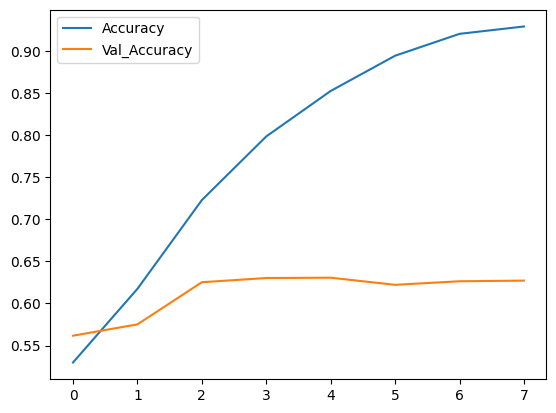

In [55]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();

In [56]:
pickle.dump(model,open('Tweet.pkl','wb'))